# This cat does not exist
__Суммарное количество баллов: 10__

Цель этого задания - создать котов, которых не существует. В ходе данного задания вы обучите DCGAN и VAE, которые являются одними из первых генеративных моделей. Для этого задания вам наверняка потребуется GPU с CUDA, поэтому рекомендуется использовать Google Colab.

In [1]:
import torch
from torch import nn
from torch.optim import Adam
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
import os 
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random
import numpy as np

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def random_noise(batch_size, channels, side_size):
    return torch.randn(batch_size, channels, side_size, side_size).cuda()

In [3]:
def visualise(imgs, rows=2):
    imgs = (imgs.transpose(1, 3) + 1) / 2
    imgs = torch.cat([imgs[i::rows] for i in range(rows)], dim=1)
    cols = len(imgs)
    imgs = (torch.cat(list(imgs), dim=1)).cpu().numpy()[:, :, ::-1]
    plt.figure(figsize=(cols*1.5, rows*1.5))
    plt.imshow(imgs)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [4]:
class CatDataset(Dataset):
    def __init__(self, path_to_dataset="cat_136", size=64):
        self.photo_names = os.listdir(path_to_dataset)
        self.path_base = path_to_dataset
        self.size = size
    
    def __getitem__(self, index):
        path = self.path_base + "/" + self.photo_names[index]
        img = cv2.imread(path) # 136 x 136
        crop_rate = 8
        x_crop = random.randint(0, crop_rate)
        y_crop = random.randint(0, crop_rate)
        img = img[x_crop:136 - crop_rate + x_crop, y_crop:136 - crop_rate + y_crop]
        img = cv2.resize(img, (self.size, self.size), interpolation=cv2.INTER_CUBIC)
        return 2 * torch.tensor(img).float().transpose(0, 2) / 255. - 1
    
    def __len__(self):
        return len(self.photo_names)

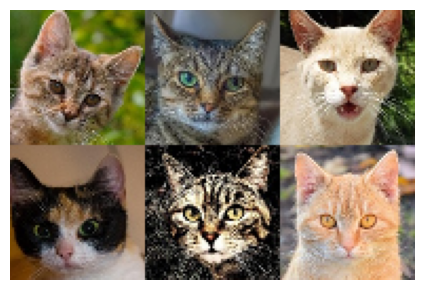

In [5]:
dataset = CatDataset()
visualise(torch.cat([dataset[i].unsqueeze(0) for i in [3, 15, 182, 592, 394, 2941]], dim=0))

### Задание 1 (2 балла)
Для начала реализуем кодировщик для нашего VAE. Предлагается использовать следующую архитектуру:

![](imgs/VAE_enc.png)

Для ее реализации вам потребуются модули `nn.Conv2d`, `nn.ReLU`, `nn.Flatten` и `nn.Linear`.

#### Методы
* `__init__` - принимает на вход `img_size`, `latent_size`, `start_channels` и `downsamplings`. Первый аргумент - высота и ширина картинки в пикселях. Второй аргумент - размерность латентного пространства. `start_channels` отвечает за то, сколько каналов должно быть в картинке перед тем, как к ней будут применены downsampling блоки. `downsamplings` - это количество downsampling блоков, которые должны быть применены к картинке. В каждом таком блоке количество каналов увеличивается в два раза.


* `forward` - принимает на вход батч `x`, возвращает эмбеддинг в латентном пространстве `z` и параметры распределения `(mu, sigma)`.

In [6]:
from task import Encoder

In [11]:
Enc=Encoder()
dataset = CatDataset(size=128)
device = torch.device("cpu")

test_imgs_1 = torch.cat([dataset[i].unsqueeze(0) for i in (0, 34, 76, 1509)])
z_1 = Enc.forward(test_imgs_1)
#print(z_1[0].shape)

### Задание 2 (3 балла)
Теперь реализуем декодер для VAE. Предлагается использовать следующую архитектуру:

![](imgs/VAE_dec.png)

Для ее реализации вам потребуются модули `nn.Linear`, `nn.Unflatten`, `nn.ConvTranspose2d`, `nn.ReLU` и `nn.Sigmoid`.

#### Методы
* `__init__` - принимает на вход `img_size`, `latent_size`, `end_channels` и `upsamplings`.  Первый аргумент - высота и ширина картинки в пикселях. Второй аргумент - размерность латентного пространства. `end_channels` отвечает за то, сколько каналов должно быть после всех upsampling блоков. `upsamplings` - это количество upsampling блоков, которые должны быть применены к картинке. В каждом таком блоке количество каналов уменьшается в два раза.


* `forward` - принимает на вход `z` - тензор с латентным представлением изображений. Возвращает батч восстановленных изображений.

#### Важно
`Linear Model` в схеме - это полносвязная сеть из нескольких слоев. Предлагается такая архитектура:

`[Linear(c * img_size // 2*N -> 256), ReLU, Linear(256 -> 2 * latent_size)]`

In [8]:
from task import Decoder

In [29]:
Dec=Decoder()
print(Dec.forward(z_1[0]))

tensor([[[[-3.7522e-01, -3.0899e-01, -3.4695e-01,  ..., -2.5267e-01,
           -3.0826e-01, -3.6758e-01],
          [-3.9773e-01, -4.8353e-01, -2.4947e-01,  ..., -5.0558e-01,
           -1.8587e-01, -4.6004e-01],
          [-4.1726e-01, -2.8875e-01, -4.0947e-01,  ..., -4.2263e-01,
           -3.4393e-01, -2.6913e-01],
          ...,
          [-4.3890e-01, -4.1048e-01, -3.8662e-01,  ..., -4.4502e-01,
           -3.5819e-01, -3.9460e-01],
          [-4.7114e-01, -2.4204e-01, -3.6779e-01,  ..., -2.4110e-01,
           -3.6232e-01, -3.6446e-01],
          [-4.0704e-01, -4.7308e-01, -3.8569e-01,  ..., -4.1673e-01,
           -2.7479e-01, -4.5918e-01]],

         [[ 1.0529e-02,  1.5585e-01, -1.0369e-01,  ...,  1.0634e-01,
           -6.0393e-02,  7.3841e-02],
          [-6.9137e-02, -4.0623e-02, -9.3547e-02,  ...,  4.0799e-02,
           -1.9726e-02, -5.6277e-03],
          [-7.5208e-02,  1.1340e-01, -7.2180e-02,  ...,  8.3776e-02,
           -3.5096e-02, -2.5609e-02],
          ...,
     

### Задание 3 (5 баллов)
Наконец, объединим Encoder и Decoder в Variational Autoencoder.

Полностью архитектура выглядит так:
![](imgs/VAE.png) 

Из нее можно выделить две части: Encoder (по изображению возвращает mu и sigma) и Decoder (по случайному шуму восстанавливает изображение). На высоком уровне VAE можно представить так:

![](imgs/VAE_highlevel.png)

В данном задании вам необходимо реализовать полную архитектуру VAE.

#### Методы
* `__init__` - принимает на вход `img_size`, `downsamplings`, `latent_size`, `linear_hidden_size`, `down_channels` и `up_channels`. `img_size` - размер стороны входного изображения. `downsamplings` - количество downsampling (и upsampling) блоков. `latent_size` - размер латентного пространства, в котором в который будет закодирована картинка. `linear_hidden_size` количество нейронов на скрытом слое полносвязной сети в конце encoder'а. Для полносвязной сети decoder'а это число стоит умножить на 2. `down_channels` - количество каналов, в которое будет преобразовано трехцветное изображение перед применением `downsampling` блоков. `up_channels` - количество каналов, которое должно получиться после применения всех upsampling блоков.

* `forward` - принимает на вход `x`. Считает распределение $N(\mu, \sigma^2)$ и вектор $z \sim N(\mu, \sigma^2)$. Возвращает $x'$ - восстановленную из вектора $z$ картинку и $D_{KL}(N(\mu, \sigma^2), N(0, 1)) = 0.5 \cdot (\sigma^2 + \mu^2 - \log \sigma^2 - 1)$.

* `encode` - принимает на вход `x`. Возвращает вектор из распределения $N(\mu, \sigma^2)$.

* `decode` - принимает на вход `z`. Возвращает восстановленную по вектору картинку.

* `save` - сохраняет чекпоинт обученной модели.

* `load` - загружает сохраненный чекпоинт обученной модели.


#### Если хочется улучшить качество
https://arxiv.org/pdf/1906.00446.pdf

In [31]:
from task import VAE

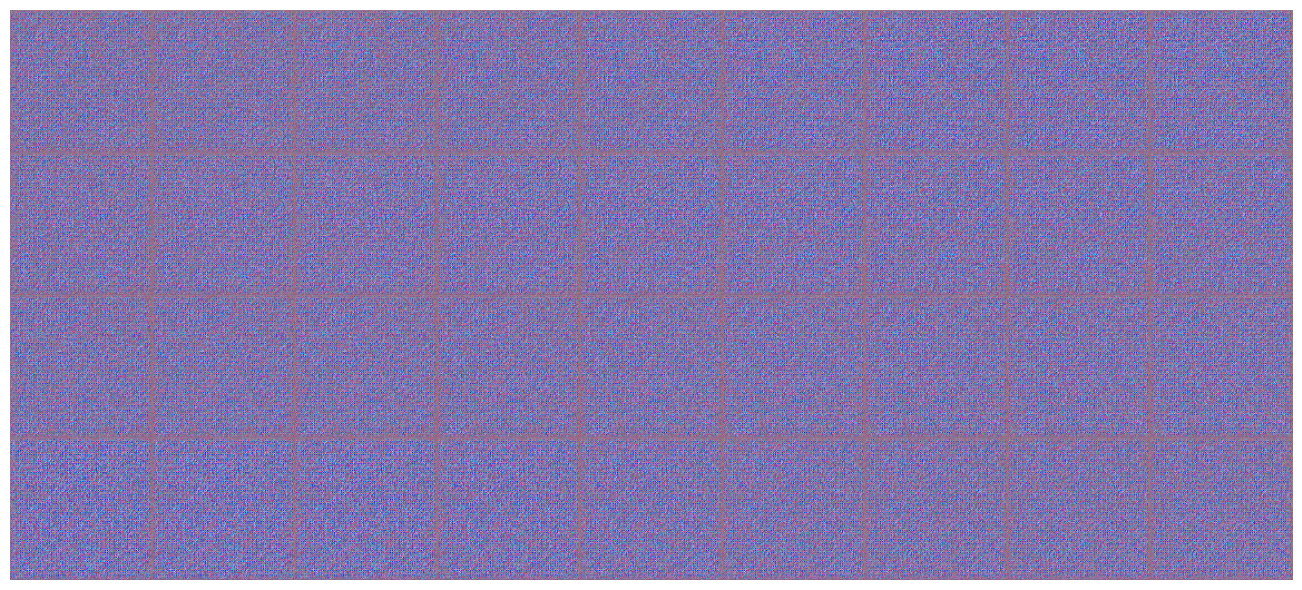

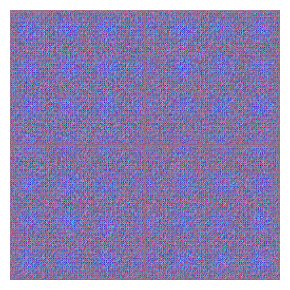

  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 1 | Reconstruction loss: 9032.1638445173 | KLD loss: 1156.0693567524786


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 2 | Reconstruction loss: 4797.845075713922 | KLD loss: 889.1677057491327


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 3 | Reconstruction loss: 4137.589849815606 | KLD loss: 955.4325943467039


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 4 | Reconstruction loss: 3769.4598305269797 | KLD loss: 998.5028304579836


  0%|          | 0/645 [00:00<?, ?it/s]

Epoch 5 | Reconstruction loss: 3448.110196510457 | KLD loss: 1016.4040807878008


  0%|          | 0/645 [00:00<?, ?it/s]

In [36]:
def train_vae():
    vae = VAE()
    #vae.cuda()

    epochs = 201
    batch_size = 8
    vae_optim = Adam(vae.parameters(), lr=1e-4)

    dataset = CatDataset(size=128)

    test_imgs_1 = torch.cat([dataset[i].unsqueeze(0) for i in (0, 34, 76, 1509)])
    test_imgs_2 = torch.cat([dataset[i].unsqueeze(0) for i in (734, 123, 512, 3634)])

    for ep in range(epochs):
        dataloader = DataLoader(dataset, shuffle=True, batch_size=batch_size)
        total_batches = 0
        rec_loss_avg = 0
        kld_loss_avg = 0

        if ep % 10 == 0:
            with torch.no_grad():
                #z_1 = vae.encode(test_imgs_1.cuda())
                #z_2 = vae.encode(test_imgs_2.cuda())
                z_1 = vae.encode(test_imgs_1)
                z_2 = vae.encode(test_imgs_2)
                x_int = []
                for i in range(9):
                    z = (i * z_1 + (8 - i) * z_2) / 8
                    x_int.append(vae.decode(z))
                x_int = torch.cat(x_int)
                visualise(x_int, rows=len(test_imgs_1))
                z_rand = torch.randn_like(z_1)
                x_int = vae.decode(z_rand)
                visualise(x_int, rows=len(test_imgs_1)//2)

        for i, batch in tqdm(enumerate(dataloader), total=(len(dataset) + batch_size) // batch_size):
            if len(batch) < batch_size:
                continue
            total_batches += 1
            #x = batch.cuda()
            x = batch
            x_rec, kld = vae(x)
            img_elems = float(np.prod(list(batch.size())))
            kld_loss = kld.sum() / batch_size
            rec_loss = ((x_rec - x)**2).sum() / batch_size
            loss = rec_loss + 0.1 * kld_loss # https://openreview.net/forum?id=Sy2fzU9gl
            vae_optim.zero_grad()
            loss.backward()
            vae_optim.step()
            kld_loss_avg += kld_loss.item()
            rec_loss_avg += rec_loss.item()

        print(f"Epoch {ep+1} | Reconstruction loss: {rec_loss_avg / total_batches} | KLD loss: {kld_loss_avg / total_batches}")

train_vae()